# table of contents
[1. 필요한 파일 불러오기 및 정리](#bullet1)<br>
[2. 데이터 EDA](#bullet2)<br>
[3. Split Data](#bullet3)<br>
[4. Similarity - with kNN](#bullet4)<br>
[5. Make Predictions](#bullet5)<br>

# 1. 필요한 파일 불러오기 및 정리<a class="anchor" id="bullet1"></a>


In [13]:
from scipy.stats import pearsonr
from datetime import datetime
import pandas as pd
import numpy as np
import seaborn as sns
import os
import random
import matplotlib
import matplotlib.pyplot as plt
from scipy import sparse
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error


In [10]:
raw = pd.read_csv('booklist.csv', encoding='cp949', index_col = False)

df = raw[['nickname', 'title',  'rating']]

df.sample(5)

,nickname,title,rating
14244,ddorg321,골든아워2,80
13507,날윤,열하일기 첫걸음,100
11054,힉스입자,딜리트,100
11926,완벽완전팟방,초등 감정 사용법,100
7660,kban,[세계환상문학선] 오스카 와일드의 환상문학선,90


## 1.1 title_df, user_df 만들기<a class="anchor" id="bullet1.1"></a>

In [15]:
user_df = pd.DataFrame(list(df.nickname	.unique()), columns = ['nickname'])
user_df['usr_id'] = random.sample(range(1,len(user_df)+1), len(user_df))

title_df = pd.DataFrame(list(df.title.unique()), columns = ['title'])
title_df['ttl_id'] = random.sample(range(1,len(title_df)+1), len(title_df))

df = df.merge(user_df, how = 'left' )
df = df.merge(title_df, how = 'left' )

df.sample(5)

,nickname,title,rating,usr_id,ttl_id
15245,meiting,운명이다,100,1590,63
7576,율리맘,빨강머리 앤 : 에이번리 이야기,100,4326,19
8300,노브레끼,"100인의 배우, 우리 문학을 읽다",60,4125,104
5419,빛나라둥이둥둥이,[공포괴담집] 저승에서 돌아온 남자,100,2018,56
1918,퐁이퐁퐁,블랙코미디,60,4088,126


In [27]:
df.columns = ['user', 'title', 'rating', 'usr_id', 'ttl_id']
df.sample()

,user,title,rating,usr_id,ttl_id
5250,korkor9657,[공포괴담집] 저승에서 돌아온 남자,80,3599,56


## 1.2 pivot_df 만들기<a class="anchor" id="bullet1.2"></a>
user가 행, title이 id


In [30]:
pivot_df = df.pivot_table('rating', index = 'user', columns = 'title')
pivot_df.sample(4)

title,"100인의 배우, 우리 문학을 읽다",1등은 당신처럼 공부하지 않았다,<테이크아웃 오디오북> 목견,[Young K 낭독] 페이퍼 컷 (단편),[강연형] 제국대학의 조센징,[공포괴담집] 무조건 모르는 척하세요,[공포괴담집] 저승에서 돌아온 남자,[규빈 낭독] 배꼽 (단편),[김대명 낭독] 세계의 호수 _ 작은책,[김도연 낭독] 림 로드 (단편),...,출판번역가로 먹고살기,친애하는 내당신에게,투명인간,파씨의 입문,편안하게 호흡을 합니다,편의점으로 먹고살기,한마디면 충분하다,해외영업으로 먹고살기,회색 인간,후아유
user,,,,,,,,,,,,,,,,,,,,,
vicodin,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
피러미드박,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
enomi,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
LUCERE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# 2. 데이터 EDA<a class="anchor" id="bullet2"></a>

In [73]:
print(f"데이터의 크기는             : {df.shape}")
print(f"데이터에 포함된 유저의 수는 : {len(user_df)}")
print(f"데이터에 포함된 책의 수는   : {len(title_df)}")

데이터의 크기는             : (15965, 5)
데이터에 포함된 유저의 수는 : 4951
데이터에 포함된 책의 수는   : 200


C:\Users\Hanna Kim\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: FixedFormatter should only be used together with FixedLocator
  This is separate from the ipykernel package so we can avoid doing imports until


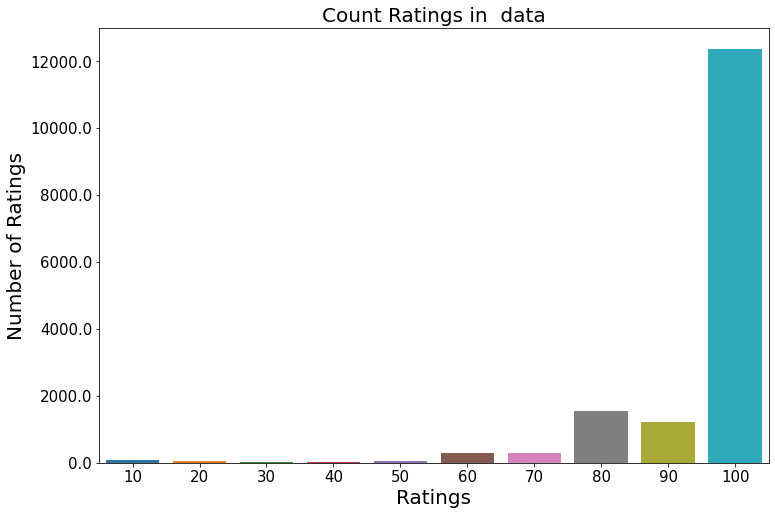

In [66]:
plt.figure(figsize = (12, 8))
ax = sns.countplot(x="rating", data=df)
ax.set_yticklabels([num for num in ax.get_yticks()])
plt.tick_params(labelsize = 15)
plt.title("Count Ratings in  data", fontsize = 20)
plt.xlabel("Ratings", fontsize = 20)
plt.ylabel("Number of Ratings", fontsize = 20)
plt.show()

일단 가장 높은 n개의 값만 보여주는 함수를 만듭니다.

In [17]:
def return_best_n(statistics, n):
    # statistics: array of size review.shape[1] containing one statistic calculated from the dataset
    # n: number of indices to be returned
    # returns: array of size *n* containing the indices of the best scored statistics
    statistics = pd.DataFrame({'statistic':statistics})
    return statistics.sort_values('statistic', ascending = False).iloc[:n]

## 2.1 Mean Rating <a class="anchor" id="bullet2.1"></a>


In [40]:
means = pivot_df.iloc[:,2:].apply(np.mean)
return_best_n(means,10)

,statistic
title,
김의성이 읽는 최인호의 타인의 방,100.0
경제 읽어주는 남자 김광석의 [디지털 경제의 미래],100.0
너의 거기는 작고 나의 여기는 커서 우리들은 헤어지는 중입니다,100.0
정진영이 읽는 김기진의 젊은 이상주의자의 사,100.0
중국식 룰렛,100.0
나만 몰랐던 이야기,100.0
어린이 성경 : 알기 쉬운 성경이야기,100.0
김용 대하역사무협 신조협려 하이라이트,100.0
김영민이 읽는 현경준의 탁류,100.0


## 2.2 Rating Count<a class="anchor" id="bullet2.2"></a>


In [44]:
count = pivot_df.iloc[:,2:].apply(lambda col : np.sum(~np.isnan(col)))

# return_best_n(count,10).index 를 구하면 제목만 뽑을 수 있음
return_best_n(count,10)

,statistic
title,
최민식이 읽는 이범선의 오발탄,1445
운명이다,598
어른이 되면 괜찮을 줄 알았다,530
딜리트,521
[강연형] 제국대학의 조센징,498
담배만이 우리 세상,480
[한예리 낭독] 안락 _ 작은책,407
살고 싶다는 농담,392
나는 왠지 대박날 것만 같아!,391


평균 평점 top10의 책은 몇개의 리뷰가 있을까?

In [48]:
top10_avg_ratings = return_best_n(means,10).index
count.loc[top10_avg_ratings]

title
김의성이 읽는 최인호의 타인의 방                    5
경제 읽어주는 남자 김광석의 [디지털 경제의 미래]          1
너의 거기는 작고 나의 여기는 커서 우리들은 헤어지는 중입니다    2
정진영이 읽는 김기진의 젊은 이상주의자의 사              2
중국식 룰렛                                1
나만 몰랐던 이야기                            1
어린이 성경 : 알기 쉬운 성경이야기                  4
김용 대하역사무협 신조협려 하이라이트                  2
김영민이 읽는 현경준의 탁류                       1
길해연이 읽는 양귀자의 원미동 시인                   1
dtype: int64

## 2.3 Percentage of Good Ratings<a class="anchor" id="bullet2.3"></a>


In [82]:
good_count = pivot_df.iloc[:,2:].apply(lambda col : np.sum(col >=  80)/np.sum(~np.isnan(col)))
return_best_n(good_count,3)

,statistic
title,
<테이크아웃 오디오북> 목견,1.0
김의성이 읽는 최인호의 타인의 방,1.0
두 도시 이야기(요약본),1.0


In [81]:
#위 코드 이해하기
col = pivot_df.iloc[:,2:]['나는 왠지 대박날 것만 같아!']
print(np.sum(col >= 80))
print(np.sum(~np.isnan(col)))

387
391


애초에 리뷰가 한개인 경우는 리뷰 수 대비 좋은 리뷰 값이 1로 나옴<br>
이걸 해결하기 위해서 리뷰 숫자가 충분한 경우만 확인

In [91]:
good_count_ratings = pd.DataFrame(good_count, columns = ['pct_of_ratings'])
good_count_ratings.sample(3)

,pct_of_ratings
title,
[규빈 낭독] 배꼽 (단편),1.000000
[혁 낭독] 이상한 용손 이야기 (단편),1.000000
[성진환 낭독] 나조차 나를 사랑하지 못하고,0.981982


In [96]:
count_ratings = pd.DataFrame(count, columns = ['no_of_ratings'])
count_ratings.sample(3)

,no_of_ratings
title,
유인촌이 읽는 안수길의 제3인간형,2
"달려라, 아비",1
나의 월급 독립 프로젝트,337


In [102]:
ratings_pct_no = good_count_ratings.merge(count_ratings,left_index=True,right_index=True,how = "inner")

ratings_pct_no.query('no_of_ratings > 100').sort_values(by='pct_of_ratings', ascending=False).head(3)

,pct_of_ratings,no_of_ratings
title,,
오만과 편견(요약본),1.000000,106
열하일기 첫걸음,0.997159,352
세계는 왜 싸우는가,0.996815,314


# 3. Split Data<a class="anchor" id="bullet3"></a>

# 4. Similarity - with kNN<a class="anchor" id="bullet4"></a>

# 5. Make Predictions<a class="anchor" id="bullet5"></a>